In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.1.0


In [32]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [3]:
# Load off the training and testing images
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
len(train_images), len(test_images)

(1250, 250)

In [4]:
# Select 10%
ten_perc_train = np.random.choice(train_images, len(train_images)//10)
len(ten_perc_train)

125

In [5]:
# Labels
mapping = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
labels_train_10_percent = [mapping[x.split("/")[2].split("_")[0]] for x in ten_perc_train]
labels_test = [mapping[x.split("/")[2].split("_")[0]] for x in test_images]

In [6]:
# tf.strings returns byte-strings
train_ds = tf.data.Dataset.list_files(str('imagenet-5-categories/train/*.jpg'), seed=666)
for f in train_ds.take(5):
    print(f.numpy())

b'imagenet-5-categories/train/elephant_1393028287_487e3bf3ba.jpg'
b'imagenet-5-categories/train/car_2663384793_2608e05f88.jpg'
b'imagenet-5-categories/train/airplane_2110882407_db1564e294.jpg'
b'imagenet-5-categories/train/cat_103392464_9743e196fb.jpg'
b'imagenet-5-categories/train/cat_1112640457_401418ec93.jpg'


In [7]:
LABELS = ["car", "dog", "elephant", "cat", "airplane"]

In [10]:
# Build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([b'car', b'dog', b'elephant', b'cat', b'airplane']),
        values=tf.constant([0, 1, 2, 3, 4]),
    ),
    default_value=tf.constant(-1),
)

# now let us do a lookup
input_tensor = tf.constant([b'car', b'dog', b'airplane', b'cat', b'elephant'])
out = table.lookup(input_tensor)
print(out)

tf.Tensor([0 1 4 3 2], shape=(5,), dtype=int32)


In [11]:
# Image preprocessing utils
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, size=[224, 224])
    image = tf.image.per_image_standardization(image)
    
    label = tf.strings.split(tf.strings.split(image_path, "/")[2], "_")[0]
    
    label = table.lookup(label)
    
    return image, label

In [12]:
# Prepare TensorFlow datasets

train_ds = tf.data.Dataset.from_tensor_slices(ten_perc_train)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = (
    test_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [13]:
# Verification utils
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(LABELS[label_batch[n].numpy()].title())
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

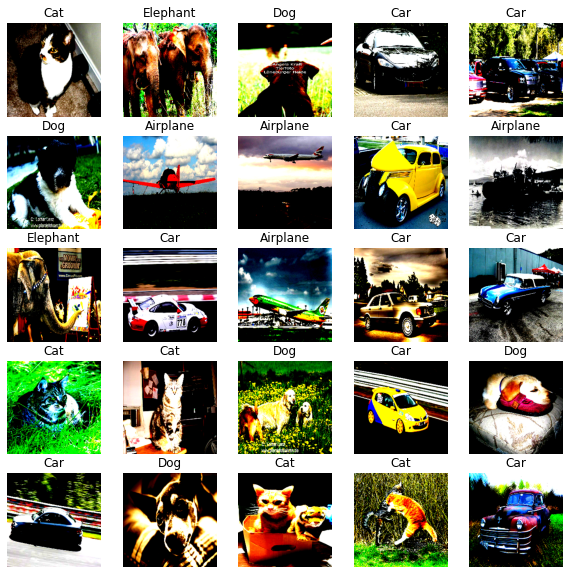

In [14]:
# Verify train images
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

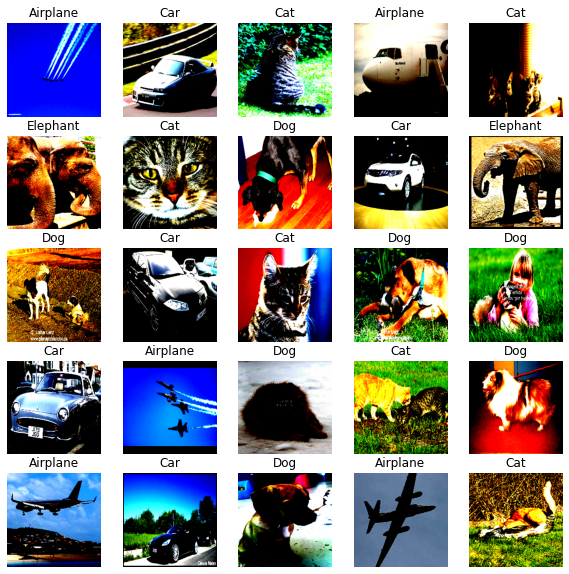

In [15]:
# Verify test images
image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch, label_batch)

In [16]:
# Architecture utils
def get_resnet_simclr_other(hidden_1, hidden_2):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    # projection_2 = Dense(hidden_2, activation="relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

resnet_simclr = get_resnet_simclr_other(512, 256)

In [17]:
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1.h5")
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
Total params: 24,768,128
Trainable params: 24,715,008
Non-trainable params: 53,120
____________________________________________

In [18]:
# We are not going to use the projections
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-3].output)
resnet_simclr_headless.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
Total params: 24,636,800
Trainable params: 24,583,680
Non-trainable params: 53,120
_________________________________________________________________


In [20]:
resnet_simclr.layers[-3].get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 512,
 'activation': 'linear',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [21]:
def get_linear_model(features):
    model = Sequential([
        Dense(5, input_shape=(features, ))
    ])
    
    return model

In [22]:
linear_classifier = get_linear_model(256)
linear_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


In [23]:
linear_optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=1e-6)
train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [26]:
def train_linear(simclr_variant, linear_classifier):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in range(50):
        for (images, labels) in train_ds:
            with tf.GradientTape() as tape:
                interm_representations = simclr_variant(images, training=False)
                y_pred = linear_classifier(interm_representations, training=True)
                loss_value = train_loss(labels, y_pred)

            # Get gradients of loss wrt the *trainable* weights.
            gradients = tape.gradient(loss_value, linear_classifier.trainable_weights)

            # Update the weights of the model.
            linear_optimizer.apply_gradients(zip(gradients, linear_classifier.trainable_weights))

            step_wise_loss.append(loss_value.numpy())

        train_acc.reset_states()
        train_acc(labels, y_pred)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} loss: {:.3f} accuracy: {:.3f}".format(epoch+1, np.mean(step_wise_loss), 
            train_acc.result().numpy()))

In [27]:
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-3].output)
linear_classifier = get_linear_model(512)
train_linear(resnet_simclr_headless, linear_classifier)

epoch: 1 loss: 9.246 accuracy: 0.279
epoch: 2 loss: 10.360 accuracy: 0.295
epoch: 3 loss: 10.737 accuracy: 0.246
epoch: 4 loss: 10.921 accuracy: 0.295
epoch: 5 loss: 11.034 accuracy: 0.262
epoch: 6 loss: 11.112 accuracy: 0.230
epoch: 7 loss: 11.161 accuracy: 0.344
epoch: 8 loss: 11.200 accuracy: 0.279
epoch: 9 loss: 11.231 accuracy: 0.295
epoch: 10 loss: 11.255 accuracy: 0.295
epoch: 11 loss: 11.276 accuracy: 0.262
epoch: 12 loss: 11.291 accuracy: 0.328
epoch: 13 loss: 11.305 accuracy: 0.295
epoch: 14 loss: 11.317 accuracy: 0.311
epoch: 15 loss: 11.329 accuracy: 0.246
epoch: 16 loss: 11.337 accuracy: 0.328
epoch: 17 loss: 11.346 accuracy: 0.262
epoch: 18 loss: 11.353 accuracy: 0.295
epoch: 19 loss: 11.360 accuracy: 0.262
epoch: 20 loss: 11.367 accuracy: 0.230
epoch: 21 loss: 11.373 accuracy: 0.246
epoch: 22 loss: 11.378 accuracy: 0.279
epoch: 23 loss: 11.382 accuracy: 0.295
epoch: 24 loss: 11.385 accuracy: 0.311
epoch: 25 loss: 11.390 accuracy: 0.246
epoch: 26 loss: 11.393 accuracy: 0.

In [30]:
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', 
                    palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.show()

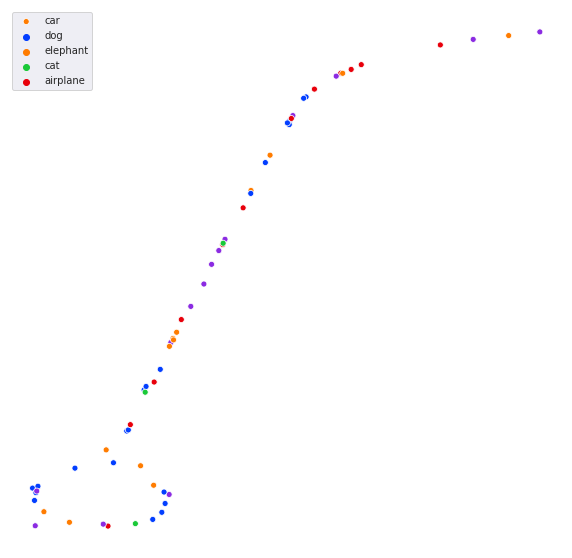

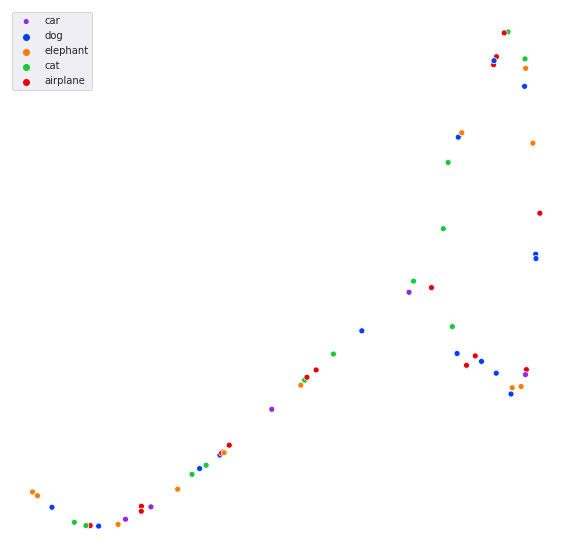

In [33]:
tsne = TSNE()
resnet_simclr = get_resnet_simclr_other(512, 256)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1.h5")

for (images, labels) in train_ds:
    interm_representations = resnet_simclr(images)
    y_tsne = tsne.fit_transform(interm_representations)
    plot_vecs_n_labels(y_tsne, labels.numpy())